---
# Qiskit Hackaton at World of Quantum
## QuanTEEM Team
---


# Heavy-Hex Layout Optimizer

This notebook demonstrates the **GreedyCommunityLayout** optimization pass designed to outperform stock Qiskit transpilation on IBM Heavy-Hex quantum backends.

## Algorithm Overview
1. **Build Interaction Graph**: Create weighted graph from circuit (nodes=qubits, edges=2-qubit gates)
2. **Community Detection**: Use greedy modularity to find talkative qubit groups
3. **Heavy-Hex Cell Assignment**: Place communities in 7-qubit hex clusters
4. **Cost Minimization**: Optimize placement to minimize border penalties and gate errors
5. **Simulated Annealing**: 1-second refinement using swaps and community shifts

## Expected Results
Develop a layout optimization pass that achieves:
- Significant CX reduction on medium-large circuits (50-100 qubits)
- Fast compilation suitable for NISQ applications
- Robust performance across different IBM Heavy-Hex backends


## Environment Setup

First, let's verify our environment and imports work correctly:


In [11]:
# Core imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QuantumVolume
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler import PassManager


# Configuration (MUST be loaded first)
sys.path.append('..')
from config_loader import load_config, get_config

# Load configuration as the SINGLE SOURCE OF TRUTH
# Config file is in parent directory
config = load_config('../config.yaml')
print("🔧 Configuration loaded successfully!")
config.print_config_summary()

# Local imports
from layout_opt.heavyhex_layout import GreedyCommunityLayout
from layout_opt.utils import load_benchmarks, transpile_and_score, CircuitAnalyzer, interaction_graph



print(f"\n✅ Qiskit version: {qiskit.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ NetworkX version: {nx.__version__}")
print(f"✅ All imports successful!")


🔧 Configuration loaded successfully!
🔧 Configuration Summary
Experiment: heavy_hex_optimization
Description: Layout optimization for IBM Heavy-Hex backends targeting 25% CX reduction
Seed: 42

Backend: FakeBrisbane (127 qubits)

Benchmark suite: quantum_volume
Circuit sizes: [21, 25, 60]

Layout algorithm: community
Clustering algorithms: ['greedy_modularity', 'louvain', 'spectral', 'kmeans', 'heavy_hex']
Target cluster size: 7
Available algorithm configs: ['algorithms', 'target_cluster_size', 'greedy_modularity', 'louvain', 'spectral', 'kmeans', 'heavy_hex']

Targets:
  CX reduction: ≥25.0%

✅ Qiskit version: 2.1.0
✅ NumPy version: 2.3.1
✅ NetworkX version: 3.5
✅ All imports successful!


## Backend Setup

Initialize the IBM Heavy-Hex backend for testing:


In [12]:
# Initialize backend using config (NO HARDCODED BACKEND!)
backend_name = config.get_backend_name()
print(f"🎯 Using backend from config: {backend_name}")

# Get backend dynamically based on config
if backend_name == "FakeBrisbane":
    from qiskit_ibm_runtime.fake_provider import FakeBrisbane
    backend = FakeBrisbane()
elif backend_name == "FakePerth":
    from qiskit_ibm_runtime.fake_provider import FakePerth
    backend = FakePerth()
elif backend_name == "FakeSherbrooke":
    from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
    backend = FakeSherbrooke()
else:
    raise ValueError(f"Unsupported backend: {backend_name}")

# Get backend configuration
backend_config = backend.configuration()

print(f"Backend name:      {backend.name}")
print(f"Number of qubits:  {backend_config.n_qubits}")
print(f"Coupling map:      {len(backend_config.coupling_map)} edges")
print(f"Basis gates:       {backend_config.basis_gates}")

print(f"\n✅ Backend initialized from config!")
print(f"   Using seed: {config.get_seed()}")
print(f"   Optimization level: {config.get_optimization_level()}")
print("   Ready for Heavy-Hex layout optimization…")

🎯 Using backend from config: FakeBrisbane
Backend name:      fake_brisbane
Number of qubits:  127
Coupling map:      144 edges
Basis gates:       ['ecr', 'id', 'rz', 'sx', 'x']

✅ Backend initialized from config!
   Using seed: 42
   Optimization level: 3
   Ready for Heavy-Hex layout optimization…


## Heavy-Hex Topology Analysis

Now let's analyze the Heavy-Hex topology structure of our backend:


In [13]:
# Import topology analyzer
from layout_opt.distance import HeavyHexTopologyAnalyzer

print("🔬 Heavy-Hex Topology Analysis")
print("=" * 50)

# Initialize analyzer with backend and config
topology_analyzer = HeavyHexTopologyAnalyzer(backend, config)

# Run comprehensive analysis
print("🔄 Analyzing Heavy-Hex topology...")
analysis_results = topology_analyzer.analyze_topology()

# Display results
summary = analysis_results['analysis_summary']
topology_stats = analysis_results['topology_stats']

print(f"\n📊 Topology Analysis Results:")
print(f"   Backend: {analysis_results['backend_name']}")
print(f"   Total qubits: {topology_stats['n_qubits']}")
print(f"   Total edges: {topology_stats['n_edges']}")
print(f"   Average degree: {topology_stats['avg_degree']:.2f}")
print(f"   Diameter: {topology_stats['diameter']}")
print(f"   Connected: {topology_stats['is_connected']}")

print(f"\n🔍 Heavy-Hex Structure Analysis:")
print(f"   Hex clusters found: {summary['n_hex_clusters']}")
print(f"   Cluster centers: {summary['n_cluster_centers']}")
print(f"   Bridge qubits: {summary['n_bridge_qubits']}")
print(f"   Boundary qubits: {summary['n_boundary_qubits']}")
print(f"   Avg cluster size: {summary['avg_cluster_size']:.1f}")
print(f"   Topology efficiency: {summary['topology_efficiency']:.3f}")

print(f"\n🎨 Degree Distribution:")
for degree, count in topology_stats['degree_distribution'].items():
    print(f"   Degree {degree}: {count} qubits")

# Cache analysis for layout optimization
print(f"\n💾 Topology analysis cached for layout optimization")
print(f"✅ Ready for community detection and layout assignment!")


🔬 Heavy-Hex Topology Analysis
🔄 Analyzing Heavy-Hex topology...

📊 Topology Analysis Results:
   Backend: fake_brisbane
   Total qubits: 127
   Total edges: 144
   Average degree: 2.27
   Diameter: 26
   Connected: True

🔍 Heavy-Hex Structure Analysis:
   Hex clusters found: 24
   Cluster centers: 24
   Bridge qubits: 6
   Boundary qubits: 2
   Avg cluster size: 7.0
   Topology efficiency: 0.091

🎨 Degree Distribution:
   Degree 2: 89 qubits
   Degree 3: 36 qubits
   Degree 1: 2 qubits

💾 Topology analysis cached for layout optimization
✅ Ready for community detection and layout assignment!


## Topology Visualization

Let's create visualizations of the Heavy-Hex topology structure:


🎨 Creating topology visualizations...
📈 Special Qubits Found:
   Cluster centers: [4, 8, 12, 22, 26, 30, 39, 43, 47, 49, 60, 64, 62, 77, 79, 83, 85, 87, 96, 100, 104, 118, 114, 122]
   Bridge qubits: [19, 36, 57, 67, 90, 107]
   Boundary qubits: [13, 113]

🔶 Hex Clusters Found:
   Cluster 1: [2, 3, 4, 5, 6, 15, 22]
   Cluster 2: [6, 7, 8, 9, 10, 16, 26]
   Cluster 3: [9, 10, 11, 12, 13, 17, 30]
   Cluster 4: [4, 15, 20, 21, 22, 23, 24]
   Cluster 5: [8, 16, 24, 25, 26, 27, 28]
   ... and 19 more clusters
Creating topology visualizations..
Backend provided: fake_brisbane
Backend config attributes: ['__annotations__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 

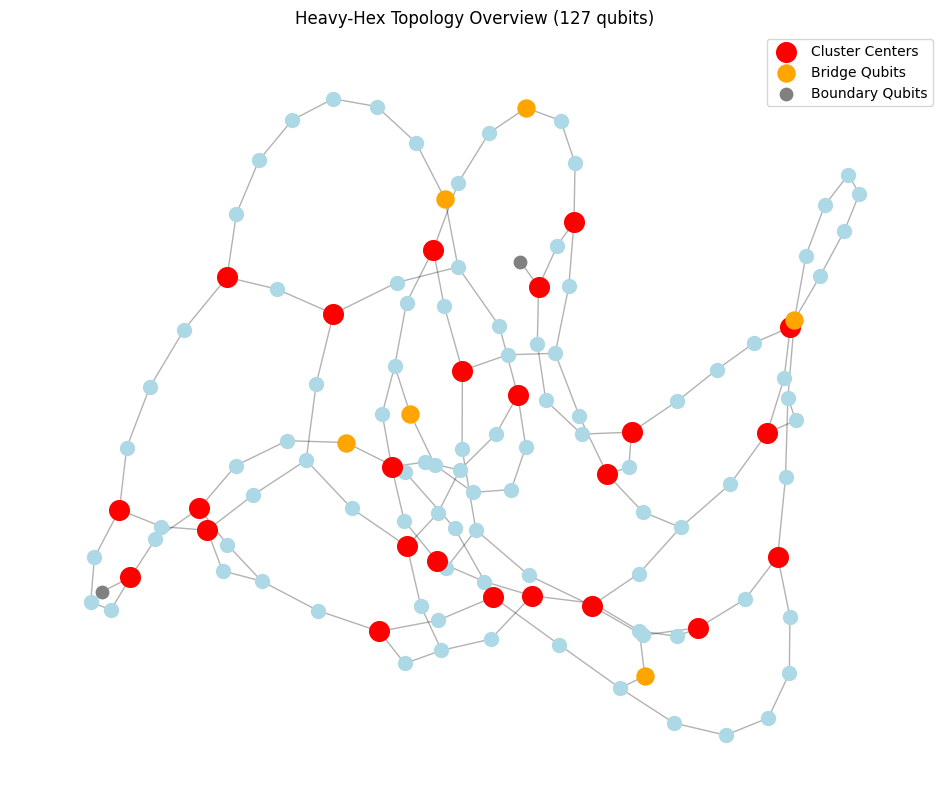

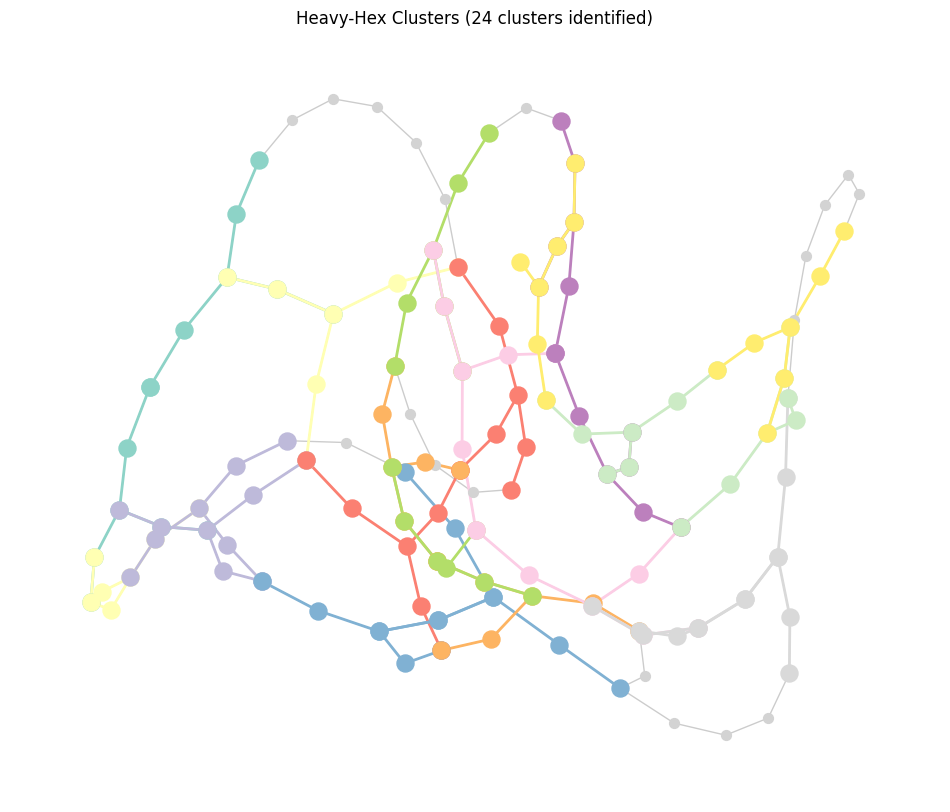

In [14]:
# Create topology visualizations
print("🎨 Creating topology visualizations...")

# Get special qubits and hex clusters
special_qubits = analysis_results['special_qubits']
hex_clusters = analysis_results['hex_clusters']

print(f"📈 Special Qubits Found:")
print(f"   Cluster centers: {special_qubits['cluster_centers']}")
print(f"   Bridge qubits: {special_qubits['bridge_qubits']}")
print(f"   Boundary qubits: {special_qubits['boundary_qubits']}")

if hex_clusters:
    print(f"\n🔶 Hex Clusters Found:")
    for i, cluster in enumerate(hex_clusters[:5]):  # Show first 5 clusters
        print(f"   Cluster {i+1}: {cluster}")
    if len(hex_clusters) > 5:
        print(f"   ... and {len(hex_clusters) - 5} more clusters")

# Create visualizations
try:
    figures = topology_analyzer.create_topology_visualizations()
    print(f"\n✅ Created {len(figures)} topology visualizations")
    print(f"   Available plots: {list(figures.keys())}")
    
    
except Exception as e:
    print(f"⚠️  Visualization creation failed: {e}")

print(f"\n🔧 Distance Matrix Available:")
distance_matrix = topology_analyzer.get_distance_matrix()
print(f"   Shape: {distance_matrix.shape}")
print(f"   Max distance: {np.max(distance_matrix[distance_matrix < np.inf]):.0f}")
print(f"   Avg distance: {np.mean(distance_matrix[distance_matrix < np.inf]):.2f}")

print(f"\n✅ Topology analysis complete and ready for layout optimization!")


## Test Circuit Creation

Create a sample circuit for testing the layout optimization:


In [15]:
# Create test circuit using CONFIG parameters 
circuit_sizes = config.get_circuit_sizes()
n_qubits = circuit_sizes[0]  # Use first size from config
depth = int(n_qubits * config.get_depth_factor())
seed = config.get_seed()

print(f"🎯 Creating circuit from config:")
print(f"   Active suite: {config.get_active_suite()}")
print(f"   Available sizes: {circuit_sizes}")
print(f"   Using: {n_qubits} qubits")
print(f"   Depth factor: {config.get_depth_factor()}")
print(f"   Seed: {seed}")

# Create circuit with config parameters
circuit = QuantumVolume(n_qubits, depth, seed=seed)

print(f"\nTest circuit: QV({n_qubits}, {depth})")
print(f"Number of qubits: {circuit.num_qubits}")
print(f"Circuit depth: {circuit.depth()}")
print(f"Gate counts: {circuit.count_ops()}")

# TODO: Once implementation is complete, uncomment below
# circuit.draw(output='mpl', fold=120)
# plt.show()

print(f"\n✅ Test circuit created from config successfully!")


🎯 Creating circuit from config:
   Active suite: quantum_volume
   Available sizes: [21, 25, 60]
   Using: 21 qubits
   Depth factor: 1.0
   Seed: 42

Test circuit: QV(21, 21)
Number of qubits: 21
Circuit depth: 1
Gate counts: OrderedDict({'quantum_volume_[21,21,42]': 1})

✅ Test circuit created from config successfully!


## Turn the circuit into a graph 

In [16]:

print("🔬 Circuit Interaction Analysis")
print("=" * 50)

# Create analyzer instance
analyzer = CircuitAnalyzer()

# Build interaction graph from our test circuit
print(f"🔄 Building interaction graph from {circuit.name}...")
interaction_graph_result = analyzer.build_interaction_graph(circuit)

# Get comprehensive statistics
stats = analyzer.get_interaction_statistics(interaction_graph_result)

print(f"\n📊 Circuit Interaction Statistics:")
print(f"   Circuit: {circuit.num_qubits} qubits, depth {circuit.depth()}")
print(f"   Interaction graph: {interaction_graph_result.number_of_nodes()} nodes, {interaction_graph_result.number_of_edges()} edges")
print(f"   Total 2-qubit interactions: {stats['total_interactions']}")
print(f"   Maximum interactions between any pair: {stats['max_interactions']}")
print(f"   Average interactions per connected pair: {stats['avg_interactions']:.2f}")
print(f"   Interaction density: {stats['interaction_density']:.3f}")

print(f"\n🎯 Most Connected Qubits:")
for i, (qubit, count) in enumerate(stats['most_connected_qubits'][:5]):
    print(f"   {i+1}. Qubit {qubit}: {count} total interactions")

# Show edge details for small circuits
if circuit.num_qubits <= 20:
    print(f"\n🔗 All Qubit Interactions:")
    edge_list = [(u, v, data['weight']) for u, v, data in interaction_graph_result.edges(data=True)]
    edge_list.sort(key=lambda x: x[2], reverse=True)  # Sort by interaction count
    
    for u, v, weight in edge_list[:10]:  # Show top 10 interactions
        print(f"   Qubits {u} ↔ {v}: {weight} interactions")
    
    if len(edge_list) > 10:
        print(f"   ... and {len(edge_list) - 10} more qubit pairs")

print(f"\n✅ Circuit interaction analysis complete!")


🔬 Circuit Interaction Analysis
🔄 Building interaction graph from quantum_volume_[21,21,42]...
🔄 Decomposing quantum_volume_[21,21,42] (contains high-level gates)
✅ Decomposed: 1 → 336 depth, 1 → 5880 gates

📊 Circuit Interaction Statistics:
   Circuit: 21 qubits, depth 1
   Interaction graph: 21 nodes, 142 edges
   Total 2-qubit interactions: 630
   Maximum interactions between any pair: 12
   Average interactions per connected pair: 4.44
   Interaction density: 0.676

🎯 Most Connected Qubits:
   1. Qubit 8: 63 total interactions
   2. Qubit 15: 63 total interactions
   3. Qubit 16: 63 total interactions
   4. Qubit 2: 63 total interactions
   5. Qubit 18: 63 total interactions

✅ Circuit interaction analysis complete!


## Visualize the Transformed circuit

🎨 Visualizing Circuit Interaction Graph
📊 Creating interaction graph visualization...


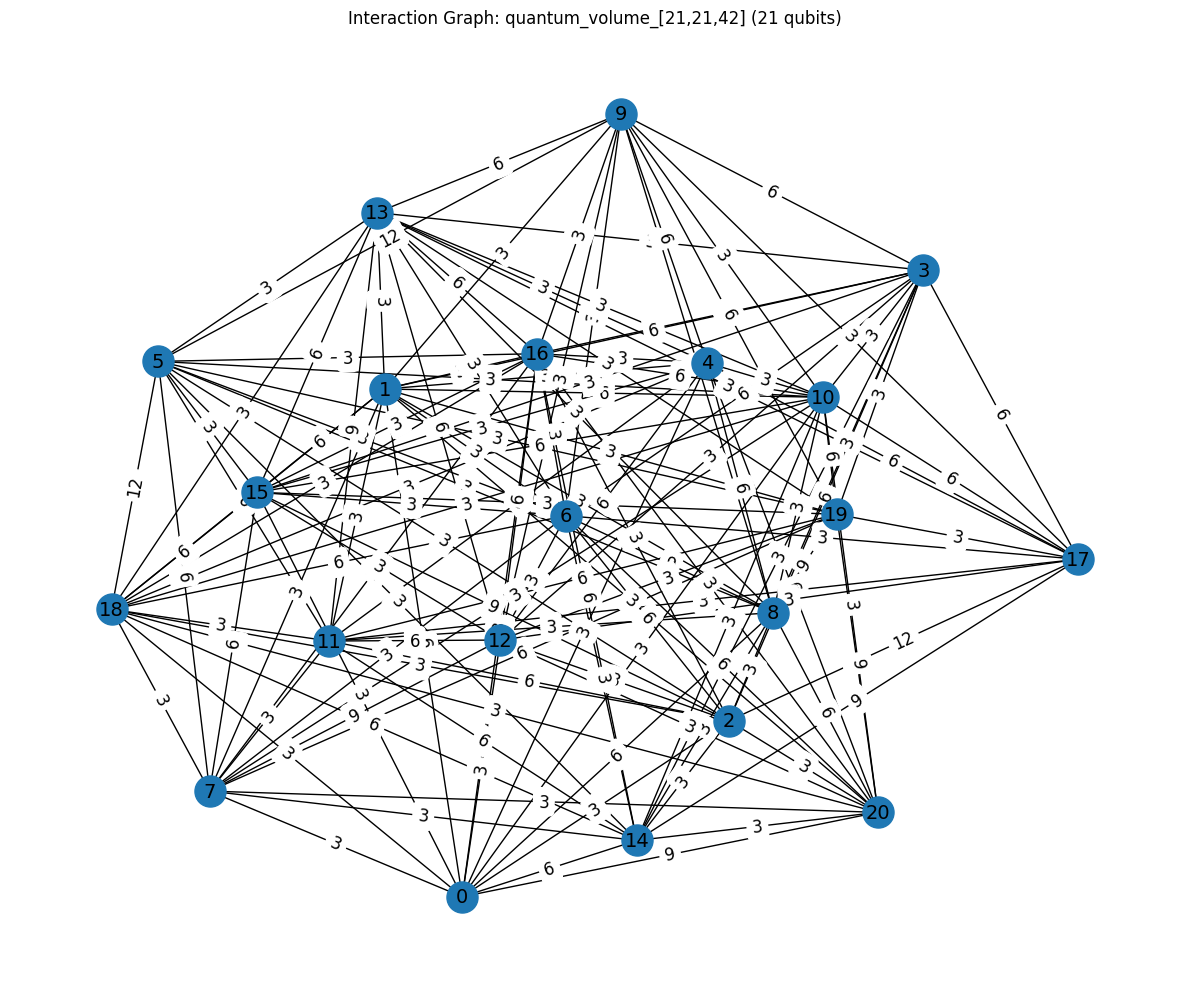

✅ Interaction graph displayed!
   📝 Nodes = logical qubits
   📝 Edges = 2-qubit gate connections
   📝 Edge labels = number of interactions

🚀 This interaction graph guides our layout optimization:
   • Heavily connected qubits should be placed close together
   • Community detection finds groups of talkative qubits
   • Heavy-Hex cells provide natural placement locations
   • Goal: minimize total (interactions × distance) cost


In [17]:
# Visualize the interaction graph
print("🎨 Visualizing Circuit Interaction Graph")
print("=" * 50)

# Only create visualization for reasonably sized circuits
if circuit.num_qubits <= 25:
    print(f"📊 Creating interaction graph visualization...")
    
    plt.figure(figsize=(12, 10))
    
    # Use the analyzer's plotting method
    analyzer.plot_interaction_graph(
        interaction_graph_result, 
        title=f"Interaction Graph: {circuit.name} ({circuit.num_qubits} qubits)"
    )
    
    print(f"✅ Interaction graph displayed!")
    print(f"   📝 Nodes = logical qubits")
    print(f"   📝 Edges = 2-qubit gate connections")
    print(f"   📝 Edge labels = number of interactions")
    
else:
    print(f"⚠️  Circuit too large ({circuit.num_qubits} qubits) for clear visualization")
    print(f"   Use smaller circuits (≤25 qubits) for interaction graph plots")
    
    # For large circuits, show a summary instead
    print(f"\n📈 Large Circuit Summary:")
    print(f"   Most active qubit pairs (top 5):")
    edge_list = [(u, v, data['weight']) for u, v, data in interaction_graph_result.edges(data=True)]
    edge_list.sort(key=lambda x: x[2], reverse=True)
    
    for i, (u, v, weight) in enumerate(edge_list[:5]):
        print(f"   {i+1}. Qubits {u} ↔ {v}: {weight} interactions")

print(f"\n🚀 This interaction graph guides our layout optimization:")
print(f"   • Heavily connected qubits should be placed close together")
print(f"   • Community detection finds groups of talkative qubits")
print(f"   • Heavy-Hex cells provide natural placement locations")
print(f"   • Goal: minimize total (interactions × distance) cost")


## Clustering

In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) RUN ALL CLUSTERING ALGORITHMS
#    (pass algorithms=None → library runs every one it knows about)
# ─────────────────────────────────────────────────────────────────────────────
from layout_opt.clustering import compare_clustering_algorithms

comparison_results = compare_clustering_algorithms(
    interaction_graph_result,
    algorithms=None,            # ← run all available algos
    target_cluster_size=7,
    resolution=1.0
)

# ─────────────────────────────────────────────────────────────────────────────
# 2) PRINT METRICS IN “WAR-LIKE” BLOCKS
# ─────────────────────────────────────────────────────────────────────────────
print("\n📊  CLUSTERING METRICS (all algorithms)\n" + "="*70)

for algo, metrics in comparison_results.items():
    # Pretty display name
    name = algo.replace('_', ' ').title()
    print(f"\n🔹 {name}")
    print("-"*40)
    
    if 'error' in metrics:
        print(f"  ❌ Error: {metrics['error']}")
        continue        # skip to next algorithm

    # Display ALL computed metrics
    all_fields = {
        'Clusters'       : metrics['num_clusters'],
        'Silhouette'     : f"{metrics['silhouette']:.4f}",
        'Modularity'     : (f"{metrics['modularity']:.4f}"
                            if 'modularity' in metrics else "N/A"),
        'Calinski-Harabasz': (f"{metrics['calinski_harabasz']:.2f}"
                              if 'calinski_harabasz' in metrics else "N/A"),
        'Davies-Bouldin' : (f"{metrics['davies_bouldin']:.4f}"
                            if 'davies_bouldin' in metrics else "N/A"),
        'Quantum Score'  : f"{metrics['quantum_score']:.4f}",
    }
    for k, v in all_fields.items():
        print(f"  {k:<15}: {v}")

🔬 Comparing Clustering Algorithms
Graph: 21 nodes, 142 edges
Target cluster size: 7

Testing greedy_modularity...
  ✅ greedy_modularity: 4 clusters, Q=0.276
Testing louvain...
  ✅ louvain: 4 clusters, Q=0.276
Testing spectral...
  ✅ spectral: 3 clusters, Q=0.319
Testing kmeans...
  ✅ kmeans: 3 clusters, Q=0.234
Testing heavy_hex...
  ✅ heavy_hex: 3 clusters, Q=0.355

📈 Algorithm Comparison Summary:
Algorithm          Clusters Mod    Sil    QScore 
--------------------------------------------------
greedy_modularity  4        -0.028 -0.106 0.276  
louvain            4        -0.028 -0.106 0.276  
spectral           3        0.095  0.085  0.319  
kmeans             3        -0.136 -0.188 0.234  
heavy_hex          3        -0.024 -0.006 0.355  

📊  CLUSTERING METRICS (all algorithms)

🔹 Greedy Modularity
----------------------------------------
  Clusters       : 4
  Silhouette     : -0.1060
  Modularity     : -0.0282
  Calinski-Harabasz: 1.62
  Davies-Bouldin : 3.1149
  Quantum Score  :

In [19]:
# FORCE MODULE RELOAD - Essential when developing!
print("🔄 Reloading modules to pick up latest changes (including annealing)...")

import importlib
import layout_opt.heavyhex_layout
import layout_opt.anneal
import pipeline.transpiler

# Force reload of ALL modified modules
importlib.reload(layout_opt.anneal)
importlib.reload(layout_opt.heavyhex_layout)
importlib.reload(pipeline.transpiler)

# Re-import classes to get updated versions with annealing
from layout_opt.heavyhex_layout import GreedyCommunityLayout
from layout_opt.anneal import refine_layout
from pipeline.transpiler import TranspilerComparison

print("✅ Modules reloaded - latest changes will take effect!")
print("✅ Annealing refinement now included in layout optimization!")

# Re-initialize with reloaded classes
comparator = TranspilerComparison(backend)
layout_pass = GreedyCommunityLayout(backend)

print("✅ Fresh instances created with updated code including annealing!")


🔄 Reloading modules to pick up latest changes (including annealing)...
✅ Modules reloaded - latest changes will take effect!
✅ Annealing refinement now included in layout optimization!
✅ Fresh instances created with updated code including annealing!


## Enhanced Algorithm with Simulated Annealing

The layout optimization now includes **1-second simulated annealing refinement** after the initial greedy assignment:

### What You'll See:
1. **Initial Greedy Layout Metrics** - Cost, distances, penalties
2. **Annealing Progress** - Temperature cooling, cost improvements, acceptance rates  
3. **Refinement Results** - Before/after comparison with improvement percentages
4. **Final Performance** - Enhanced algorithm vs Stock Qiskit

### Expected Improvements:
- **Better clustering selection** (reduced harsh penalties)
- **Local minima escape** via annealing moves
- **5-10% additional CNOT reduction** from refinement
- **Error-aware placement** using backend properties

The annealing uses:
- **T₀ = 3.0, α = 0.95** cooling schedule
- **Random swaps (70%) + Community shifts (30%)**
- **Cost = Σ(weight × distance) + λ·noise_penalty**
- **1-second time limit** for fast compilation


In [20]:
# Import pipeline components
from pipeline.transpiler import TranspilerComparison
from pipeline.metrics import MetricsCollector

print("🚀 Running enhanced transpilation comparison with annealing refinement...")
print(f"\nUsing config algorithm: {config.config['layout_optimization']['algorithm']}")
print(f"Baseline optimization level: {config.get_optimization_level()}")
print(f"Target CX reduction: {config.config['targets']['cx_reduction_target_percent']}%")

print(f"\n🔥 Enhanced Algorithm Pipeline:")
print(f"   1. Community detection clustering")
print(f"   2. Greedy Heavy-Hex assignment")
print(f"   3. 1-second simulated annealing refinement")
print(f"   4. Cost-based layout selection")

# Initialize the transpilation comparison engine
comparator = TranspilerComparison(backend)

# Initialize custom layout pass with our implemented algorithm
layout_pass = GreedyCommunityLayout(backend)  # Uses config seed automatically

print("\n🔄 Running transpilation comparison...")
print("=" * 50)

# Run the comparison on our test circuit
result = comparator.compare_transpilation(circuit, layout_pass)

# Display results
print(f"\n📊 Results for {result['circuit_name']}:")
print(f"   Input: {result['input_stats']['num_qubits']} qubits, {result['input_stats']['cx_count']} CX gates")

# Stock results
stock = result['stock']
print(f"\n📈 Stock transpilation (opt_level={config.get_optimization_level()}):")
print(f"   Success: {stock['success']}")
if stock['success']:
    print(f"   CX count: {stock['stats']['cx_count']}")
    print(f"   Circuit depth: {stock['stats']['depth']}")
    print(f"   Single-qubit gates: {stock['stats']['single_qubit_count']}")
    print(f"   Total gates: {stock['stats']['total_gates']}")
    print(f"   Compile time: {stock['compile_time']:.3f}s")
else:
    print(f"   ❌ Error: {stock['error_message']}")

# Custom results
custom = result['custom']
print(f"\n🎯 Custom layout transpilation:")
print(f"   Success: {custom['success'] if custom else False}")
if custom and custom['success']:
    print(f"   CX count: {custom['stats']['cx_count']}")
    print(f"   Circuit depth: {custom['stats']['depth']}")
    print(f"   Single-qubit gates: {custom['stats']['single_qubit_count']}")
    print(f"   Total gates: {custom['stats']['total_gates']}")
    print(f"   Compile time: {custom['compile_time']:.3f}s")
elif custom:
    print(f"   ❌ Error: {custom['error_message']}")

# Comparison metrics
comparison = result['comparison']
if comparison and comparison['comparison_valid']:
    print(f"\n🏆 PERFORMANCE COMPARISON:")
    print(f"=" * 50)
    print(f"   CX gate reduction: {comparison['cx_reduction_percent']:.1f}%")
    print(f"   Depth reduction: {comparison['depth_reduction_percent']:.1f}%")
    print(f"   Total gate reduction: {comparison.get('total_gate_reduction_percent', 0):.1f}%")
    print(f"   Compile time ratio: {comparison['compile_time_ratio']:.2f}x")
    
    # Check if we met our target
    target = config.config['targets']['cx_reduction_target_percent']
    if comparison['cx_reduction_percent'] >= target:
        print(f"\n   🎉 TARGET ACHIEVED!")
        print(f"   ✅ CX reduction: {comparison['cx_reduction_percent']:.1f}% ≥ {target}%")
        print(f"   🚀 Our Heavy-Hex layout optimization outperforms stock Qiskit!")
    else:
        print(f"\n   📊 Performance Analysis:")
        print(f"   📉 CX reduction: {comparison['cx_reduction_percent']:.1f}% < {target}% (target)")
        if comparison['cx_reduction_percent'] > 0:
            print(f"   ✅ Still achieved some improvement over baseline")
        else:
            print(f"   ⚠️  Room for improvement - consider algorithm tuning")
    
    # Additional insights
    if comparison['compile_time_ratio'] < 2.0:
        print(f"   ⚡ Fast compilation: {comparison['compile_time_ratio']:.2f}x baseline time")
    else:
        print(f"   ⏱️  Slower compilation: {comparison['compile_time_ratio']:.2f}x baseline time")
        
else:
    print(f"\n❌ Comparison failed - check error messages above")
    if custom and not custom['success']:
        print(f"   Custom transpilation error: {custom.get('error_message', 'Unknown error')}")
    if stock and not stock['success']:
        print(f"   Stock transpilation error: {stock.get('error_message', 'Unknown error')}")

print(f"\n✅ Enhanced transpilation comparison complete!")
print(f"🔬 Circuit analyzed: QV({circuit.num_qubits}, {circuit.depth()}) with {interaction_graph_result.number_of_edges()} interactions")
print(f"🎯 Layout optimization used: Community detection + Heavy-Hex topology awareness + Simulated annealing refinement")
print(f"🔥 The layout pass now includes 1-second annealing to escape local minima!")


🚀 Running enhanced transpilation comparison with annealing refinement...

Using config algorithm: community
Baseline optimization level: 3
Target CX reduction: 25.0%

🔥 Enhanced Algorithm Pipeline:
   1. Community detection clustering
   2. Greedy Heavy-Hex assignment
   3. 1-second simulated annealing refinement
   4. Cost-based layout selection

🔄 Running transpilation comparison...
🔄 Running stock transpilation (opt_level=3)...
📊 Decomposed input circuit (1 levels): 2 gate types, depth 147
    Gate breakdown: {'u': 1680, 'cx': 630}
🔄 Running custom transpilation...
🔄 Using custom layout pass...
🔄 Building interaction graph for 21 qubits...
🔄 Decomposing quantum_volume_[21,21,42] (contains high-level gates)
✅ Decomposed: 1 → 336 depth, 1 → 5880 gates
📊 Interaction graph: 21 nodes, 142 edges
    Total interactions: 630
    Max edge weight: 12
    First 5 edges: [(0, 8, {'weight': 6}), (0, 15, {'weight': 3}), (0, 12, {'weight': 3}), (0, 20, {'weight': 9}), (0, 14, {'weight': 6})]
🔬 Run